In [36]:
import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from IPython.display import display, HTML
from statsmodels import robust
import pickle
from scipy.ndimage import filters
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import auc
from tqdm import tqdm
display(HTML("<style>.container { width:65% !important; }</style>"))

## Supervised behavior segmentation

Functions

In [37]:
import difflib
import h5py

def format_boris(boris_path, boris_fps=40):
    
    # load boris data if given full path in str; fps is given by boris csv

    boris_df = pd.read_csv(boris_path, skiprows=16, sep=',', header=None).drop([1, 2, 3, 4, 6, 7], axis=1)
    if boris_df.iloc[0, 0] == 'Time':
        boris_df = boris_df.iloc[1:, :]
    boris_df.columns = ['Frame', 'Behavior', 'State']
    boris_df['Frame'] = boris_df['Frame'].astype(float) * boris_fps
    boris_df['Frame'] = boris_df['Frame'].astype(int)

    return boris_df

def extract_frames(z):
    # extract frame indices for behaviors of interest from boris file
    z = [np.arange(behs['Frame'].values[z[i]], behs['Frame'].values[z[i+1]]+1) for i, l in enumerate(z) if i % 2 == 0]
    return np.concatenate(z).ravel()

def split_trials(lst, n=1):
    # splits frame groups of behaviors for PETH analysis
    indices = [i + 1 for (x, y, i) in zip(lst, lst[1:], range(len(lst))) if n < abs(x - y)]
    return [lst[start:end] for start, end in zip([0] + indices, indices + [len(lst)])]


Inits

In [38]:
boris_dir = '//Volumes/Storage/boris/boris_exports/'
boris_files = np.sort([boris_dir + x for x in os.listdir(boris_dir) if '.csv' in x and '._' not in x])
print('Sample boris files:')
print(boris_files[:3])
features_dir = '//Volumes/Storage/data/processed_features_020924/'
feature_files = np.sort([features_dir + x for x in os.listdir(features_dir) if '.parquet' in x])
print('Sample feature files:')
print(feature_files[:3])
h5_dir =  '//Volumes/Storage/data/h5_files/h5_files/'
h5_files = np.sort([h5_dir + x for x in os.listdir(h5_dir) if '.h5' in x])
print('Sample h5 files:')
print(h5_files[:3])

Sample boris files:
['//Volumes/Storage/boris/boris_exports/107352_d2_balbc.csv'
 '//Volumes/Storage/boris/boris_exports/29L_d8_balbc_t2.csv'
 '//Volumes/Storage/boris/boris_exports/29L_d8_balbc_t3.csv']
Sample feature files:
['//Volumes/Storage/data/processed_features_020924/100566_d1_balbc_zscored_features.parquet'
 '//Volumes/Storage/data/processed_features_020924/100566_d2_balbc_zscored_features.parquet'
 '//Volumes/Storage/data/processed_features_020924/100566_d3_balbc_zscored_features.parquet']
Sample h5 files:
['//Volumes/Storage/data/h5_files/h5_files/107335_d1_balbc_spinview_topCam-01152022190015-0000.avi.mp4.CLEANED.slp.h5'
 '//Volumes/Storage/data/h5_files/h5_files/107335_d2_balbc_spinview_topCam-01162022191041-0000.avi.mp4.CLEANED.slp.h5'
 '//Volumes/Storage/data/h5_files/h5_files/107335_d3_balbc_spinview_topCam-01172022170829-0000.avi.mp4.CLEANED.slp.h5']


In [19]:
			   # DISTANCES
feats_list1 =  ['proximity', 'resident2intruder head-head', 'resident2intruder head-tti', 'intruder2resident head-tti',
			   # SOCIAL ORIENTATIONS
			   'resident2intruder head2centroid angle', 'intruder2resident head2centroid angle',
			   # SPEEDS
			   'resident centroid roc 100 ms', 'intruder centroid roc 100 ms', 'resident head roc 100 ms', 'intruder head roc 100 ms',
			   # POSTURAL INFORMATION
			   'resident centroid2nose angle', 'intruder centroid2nose angle', 'resident tti2head', 'intruder tti2head']

			   # DISTANCES
feats_list2 =  ['proximity', 'resident2intruder head-head', 'resident2intruder head-tti', 'intruder2resident head-tti',
			   # SOCIAL ORIENTATIONS
			   'resident2intruder head2centroid angle', 'intruder2resident head2centroid angle',
			   # SPEEDS
			   'resident centroid roc 100 ms', 'intruder centroid roc 100 ms', 'resident head roc 100 ms', 'intruder head roc 100 ms',
			   'resident centroid roc 100 ms sum across lags', 'intruder centroid roc 100 ms sum across lags', 'resident head roc 100 ms sum across lags', 'intruder head roc 100 ms sum across lags',
			   # IoU
			   'ious',
			   # POSTURAL INFORMATION
			   'resident centroid2nose angle', 'intruder centroid2nose angle', 'resident tti2head', 'intruder tti2head']

			   # DISTANCES
feats_list3 =  ['proximity', 'resident2intruder head-head', 'resident2intruder head-tti', 'intruder2resident head-tti',
			   # SOCIAL ORIENTATIONS
			   'resident2intruder head2centroid angle', 'intruder2resident head2centroid angle',
			   # SPEEDS
			   'resident centroid roc 100 ms', 'intruder centroid roc 100 ms', 'resident head roc 100 ms', 'intruder head roc 100 ms',
			   'resident centroid roc 100 ms sum across lags', 'intruder centroid roc 100 ms sum across lags', 'resident head roc 100 ms sum across lags', 'intruder head roc 100 ms sum across lags',
			   # IoU and pixel change
			   'ious',
			   # POSTURAL INFORMATION
			   'resident centroid2nose angle', 'intruder centroid2nose angle', 'resident tti2head', 'intruder tti2head']

			   # DISTANCES
feats_list4 =  ['proximity', 'resident2intruder head-head', 'resident2intruder head-tti', 'intruder2resident head-tti',
			   # SOCIAL ORIENTATIONS
			   'resident2intruder head2centroid angle', 'intruder2resident head2centroid angle',
			   # SPEEDS
			   'resident centroid roc 100 ms', 'intruder centroid roc 100 ms', 'resident head roc 100 ms', 'intruder head roc 100 ms', 'proximity roc 100 ms',
			   'resident centroid roc 100 ms sum across lags', 'intruder centroid roc 100 ms sum across lags', 'resident head roc 100 ms sum across lags', 'intruder head roc 100 ms sum across lags',
			   'proximity roc 100 ms sum across lags',
			   # IoU and pixel change
			   'ious',
			   # POSTURAL INFORMATION
			   'resident centroid2nose angle', 'intruder centroid2nose angle', 'resident tti2head', 'intruder tti2head']

			   
feats_list5 =  ['ious sum across lags', 'resident centroid roc 50 ms', 'intruder centroid roc 50 ms', 'resident head roc 50 ms', 'intruder head roc 50 ms',
				'resident centroid roc 50 ms sum across lags', 'intruder centroid roc 50 ms sum across lags', 'resident head roc 50 ms sum across lags', 'intruder head roc 50 ms sum across lags',
				'resident centroid roc 500 ms', 'intruder centroid roc 500 ms', 'resident head roc 500 ms', 'intruder head roc 500 ms',
				'resident centroid roc 500 ms sum across lags', 'intruder centroid roc 500 ms sum across lags', 'resident head roc 500 ms sum across lags', 'intruder head roc 500 ms sum across lags']


feats_list = list(set(feats_list1 + feats_list2 + feats_list3 + feats_list4 + feats_list5))
feats_list.sort()
feats_list = np.asarray(feats_list)

# from tqdm import tqdm

features = {}
implanted_list = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '29L', '30R2', '30B', '91R2', '30L', '87R2', '87L', '87B', '87L2', '86L', '86L2']
feats_path = "//Volumes/Storage/data/processed_features_020924/"
feat_pickles = np.sort([x for x in os.listdir(feats_path) if 'zscored' in x])
for session in tqdm(np.sort(feat_pickles)):
    if any(imp in session for imp in implanted_list):
        n = 4
    else:
        n = 3
    z = pd.read_parquet(feats_path + session, columns=feats_list)
    features['_'.join(session.split('_')[:n])] = z

100%|██████████| 504/504 [03:40<00:00,  2.29it/s]


Extract frames

In [20]:
### filter out boris files for ones that contain aggression and investigation
from pandas.errors import EmptyDataError
all_bfiles = {}
for bfile in boris_files:
    try: behs = format_boris(bfile)
    except EmptyDataError: continue
    # check if there is aggression
    if behs['Behavior'].str.contains('unilateral_attack_resident|fight_from_resident_with_resistance|attack/fight|fight_from_intruder_with_resistance').any():
        print('Writing %s into all_bfiles' % (bfile.split('/')[-1].split('.')[0]))
        all_bfiles[bfile.split('/')[-1].split('.')[0]] = behs

Writing 107352_d2_balbc into all_bfiles
Writing 29L_d8_balbc_t2 into all_bfiles
Writing 29L_d8_balbc_t3 into all_bfiles
Writing 29L_d9_OBSmCD1_t1 into all_bfiles
Writing 29L_d9_mCD1_t1 into all_bfiles
Writing 29L_d9_mCD1_t2 into all_bfiles
Writing 3095_d2_balbc_t3 into all_bfiles
Writing 3095_d3_balbc_t1 into all_bfiles
Writing 3095_d3_balbc_t2 into all_bfiles
Writing 3095_d3_balbc_t3 into all_bfiles
Writing 3095_d4_balbc_t1 into all_bfiles
Writing 3095_d4_balbc_t2 into all_bfiles
Writing 3095_d4_balbc_t3 into all_bfiles
Writing 3095_d5_balbc_t1 into all_bfiles
Writing 3095_d5_balbc_t2 into all_bfiles
Writing 3095_d5_balbc_t3 into all_bfiles
Writing 3095_d6_balbc_t1 into all_bfiles
Writing 3095_d8_balbc_t1 into all_bfiles
Writing 3095_d9_mCD1_t2 into all_bfiles
Writing 3095_d9_mCD1_t3 into all_bfiles
Writing 3097_d9_mCD1_t3 into all_bfiles
Writing 30B_d9_mCD1_t3 into all_bfiles
Writing 30L_d4_balbc_t1 into all_bfiles
Writing 30L_d8_balbc_t1 into all_bfiles
Writing 30L_d9_mCD1_t1 into a

In [33]:
n_videos = len(all_bfiles.keys())
print('Number of videos with aggression: %d' % n_videos)

Number of videos with aggression: 49


In [21]:
attack_frames = {}
investigation_frames = {}

agg_integer_encoded_frames = {}
inv_integer_encoded_frames = {}

for i, file in enumerate(all_bfiles.keys()):

    # load boris file

    behs = all_bfiles[file]
    print(file)

    # match frame indices between boris file and slp file

    h5_frame_check = [x for x in h5_files if file in x][0]
    print(h5_frame_check)
    pickle_frame_check = [x for x in feature_files if file in x][0]
    print(pickle_frame_check)
    
    # load datasets
    
    with h5py.File(h5_frame_check, "r") as z:
        occupancy_matrix = z['track_occupancy'][:]
        
    feature_data = features[file]
    
    # compute frame diff
    frame_diff_slp = occupancy_matrix.shape[0] - feature_data.shape[0]
    # frame_diff_slp = 0
    new_behs = behs.copy()
    new_behs['Frame'] = behs['Frame'] - frame_diff_slp
    idxs2keep = np.where(new_behs['Frame'] >= 0)[0]
    new_behs = new_behs.iloc[idxs2keep]
    if new_behs['State'].iloc[0] == 'STOP':
        new_behs = behs.iloc[1:]
        
    
    ### extract attack frames ### 

    encoded_integers = np.zeros((feature_data.shape[0]))
    # encoded_integers = np.zeros((occupancy_matrix.shape[0]))

    try: atk1_idxs = np.where(new_behs['Behavior'] == 'unilateral_attack_resident')[0]
    except IndexError: atk1_idxs = []

    try: atk2_idxs = np.where(new_behs['Behavior'] == 'fight_from_resident_with_resistance')[0]
    except IndexError: atk2_idxs = []

    try: atk3_idxs = np.where(new_behs['Behavior'] == 'attack/fight')[0]
    except IndexError: atk3_idxs = []

    try: atk4_idxs = np.where(new_behs['Behavior'] == 'fight_from_intruder_with_resistance')[0]
    except IndexError: atk4_idxs = []

    # initialize an empty list to store non-empty arrays
    non_empty_arrays = []
    list_of_arrays = [atk1_idxs, atk2_idxs, atk3_idxs, atk4_idxs]

    # iterate through the list
    for array in list_of_arrays:
        # check if the array is not empty
        if len(array) != 0:
            # concatenate the array to the new list
            non_empty_arrays.append(array)
    
    non_empty_arrays = np.concatenate(non_empty_arrays)

    # sort the new list
    idxs = np.sort(np.array(non_empty_arrays))

    frames = []
    for i, val in enumerate(new_behs.iloc[idxs]['Frame']):
        if i % 2 == 0:
            frames.append(np.arange(val, new_behs.iloc[idxs]['Frame'].iloc[i+1]))
    frames = np.concatenate(frames)
    attack_frames[file] = frames
    
    for f in frames:
        encoded_integers[f] = 1
    
    agg_integer_encoded_frames[file] = encoded_integers

107352_d2_balbc
//Volumes/Storage/data/h5_files/h5_files/107352_d2_balbc_spinview_topCam-03032022181704-0000.avi.mp4.CLEANED.slp.h5
//Volumes/Storage/data/processed_features_020924/107352_d2_balbc_zscored_features.parquet
29L_d8_balbc_t2
//Volumes/Storage/data/h5_files/h5_files/29L_d8_balbc_t2_topCam-05112023151303-0000.avi.mp4.CLEANED.slp.h5
//Volumes/Storage/data/processed_features_020924/29L_d8_balbc_t2_zscored_features.parquet
29L_d8_balbc_t3
//Volumes/Storage/data/h5_files/h5_files/29L_d8_balbc_t3_topCam-05112023153043-0000.avi.mp4.CLEANED.slp.h5
//Volumes/Storage/data/processed_features_020924/29L_d8_balbc_t3_zscored_features.parquet
29L_d9_OBSmCD1_t1
//Volumes/Storage/data/h5_files/h5_files/29L_d9_OBSmCD1_t1_topCam-05012023160242-0000.avi.mp4.CLEANED.slp.h5
//Volumes/Storage/data/processed_features_020924/29L_d9_OBSmCD1_t1_zscored_features.parquet
29L_d9_mCD1_t1
//Volumes/Storage/data/h5_files/h5_files/29L_d9_mCD1_t1_topCam-05122023162500-0000.avi.mp4.CLEANED.slp.h5
//Volumes/St

#### Format for RFC

Do y

In [22]:
unstacked_labels = []


agg_unstacked_labels = []

for key in agg_integer_encoded_frames.keys():
    agg_unstacked_labels.append(agg_integer_encoded_frames[key])
    # inv_unstacked_labels.append(inv_integer_encoded_frames[key])
    
y = np.hstack(agg_unstacked_labels)


Do X

In [23]:
sessions = list(agg_integer_encoded_frames.keys())
unpacked_features = [features[x] for x in sessions]
X = np.concatenate(unpacked_features, axis=0)

In [24]:
def temporal_resample(X, y, window_size):

    data = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)

    # Separate the minority and majority classes
    minority_data = data[data.iloc[:, -1] == 1]
    majority_data = data[data.iloc[:, -1] == 0]

    # Calculate the number of samples to generate
    num_samples = len(majority_data) - len(minority_data)

    # Generate new samples
    new_samples = minority_data.sample(n=num_samples, replace=True, random_state=42)

    # Add the new samples to the original data
    resampled_data = pd.concat([majority_data, new_samples])

    # Sort the data by the time column to maintain temporal structure
    resampled_data = resampled_data.sort_index()

    # Separate resampled X and y
    X_resampled = resampled_data.iloc[:, :-1]
    y_resampled = resampled_data.iloc[:, -1]

    return X_resampled, y_resampled

X_resampled, y_resampled = temporal_resample(X.copy(), y.copy(), window_size=100)
y_resampled = y_resampled.values
X_resampled = X_resampled.values

In [31]:
orig_attacks = np.where(y == 1)
print('Original number of attacks:', len(orig_attacks[0]))
print('Original number of non-attacks:', len(y) - len(orig_attacks[0]))

resampled_attacks = np.where(y_resampled == 1)
print('Resampled number of attacks:', len(resampled_attacks[0]))
print('Resampled number of non-attacks:', len(y_resampled) - len(resampled_attacks[0]))

Original number of attacks: 29805
Original number of non-attacks: 729269
Resampled number of attacks: 699464
Resampled number of non-attacks: 729269


## Build model and run predictions

#### Using a Keras MLP classifier

In [2]:
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 2.11.0
TensorFlow version: 2.11.0


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras import backend as K

def f1_score_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

def precision_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def balanced_accuracy_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    predicted_negatives = K.sum(K.round(K.clip(1 - y_pred, 0, 1)))
    balanced_accuracy = 0.5 * (true_positives / (predicted_positives + K.epsilon()) + true_negatives / (predicted_negatives + K.epsilon()))
    return balanced_accuracy

2024-10-29 10:13:10.961427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Prepare data:

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=0, shuffle=True)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

Create model and fit:

In [71]:
# Define the function to create the MLP model
def create_nn(hidden_units=64):
    model = keras.Sequential()
    model.add(keras.layers.Dense(hidden_units, activation='relu', input_shape=(len(feats_list),)))
    model.add(BatchNormalization())
    model.add(keras.layers.Dense(hidden_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(keras.layers.Dense(hidden_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[balanced_accuracy_metric, precision_metric])
    return model

# create model
model = create_nn(hidden_units=512)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# fit
model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/50
7479/7479 [==============================] - 66s 9ms/step - loss: 0.0735 - balanced_accuracy_metric: 0.9757 - precision_metric: 0.9652 - val_loss: 0.0423 - val_balanced_accuracy_metric: 0.9872 - val_precision_metric: 0.9758
Epoch 2/50
7479/7479 [==============================] - 66s 9ms/step - loss: 0.0372 - balanced_accuracy_metric: 0.9886 - precision_metric: 0.9828 - val_loss: 0.0394 - val_balanced_accuracy_metric: 0.9886 - val_precision_metric: 0.9850
Epoch 3/50
7479/7479 [==============================] - 64s 9ms/step - loss: 0.0283 - balanced_accuracy_metric: 0.9916 - precision_metric: 0.9874 - val_loss: 0.0280 - val_balanced_accuracy_metric: 0.9921 - val_precision_metric: 0.9908
Epoch 4/50
7479/7479 [==============================] - 77s 10ms/step - loss: 0.0235 - balanced_accuracy_metric: 0.9930 - precision_metric: 0.9896 - val_loss: 0.0214 - val_balanced_accuracy_metric: 0.9940 - val_precision_metric: 0.9903
Epoch 5/50
7479/7479 [==============================] - 79s

In [41]:
# make model validations using balanced accuracy
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred = loaded_model.predict(X) # original, non-resampled data
# y_pred = model.predict(X)
y_pred_labels = (y_pred > 0.5).astype(int)
print('balanced accuracy: %f' % balanced_accuracy_score(y, y_pred_labels))
print('precision: %f' % precision_score(y, y_pred_labels))
print('f1 score: %f' % f1_score(y, y_pred_labels))
print('recall: %f' % recall_score(y, y_pred_labels))
      

23722/23722 [==============================] - 37s 2ms/step
balanced accuracy: 0.998253
precision: 0.931085
f1 score: 0.964094
recall: 0.999530


(array([0.5, 1.5]),
 [Text(0, 0.5, 'Actual Negative'), Text(0, 1.5, 'Actual Positive')])

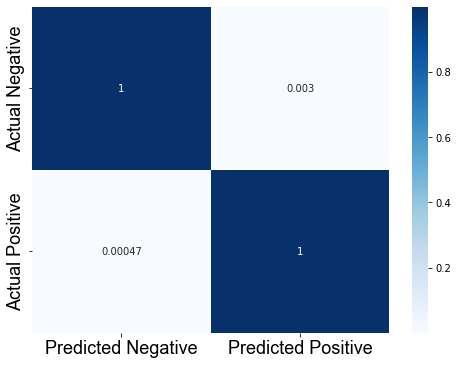

In [45]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y, y_pred_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xticks(fontsize=18, fontfamily='Arial')
plt.yticks(fontsize=18, fontfamily='Arial')
# plt.savefig('confusion_matrix.svg', dpi=300)


In [44]:
# make model validations using balanced accuracy
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred_validation = loaded_model.predict(X_test) # validation set, resampled
y_pred_labels_validation = (y_pred_validation > 0.5).astype(int)
print('balanced accuracy: %f' % balanced_accuracy_score(y_test, y_pred_labels_validation))
print('precision: %f' % precision_score(y_test, y_pred_labels_validation))
print('f1 score: %f' % f1_score(y_test, y_pred_labels_validation))
print('recall: %f' % recall_score(y_test, y_pred_labels_validation))
      

14734/14734 [==============================] - 23s 2ms/step
balanced accuracy: 0.998000
precision: 0.996312
f1 score: 0.997924
recall: 0.999540


(array([0.5, 1.5]),
 [Text(0, 0.5, 'Actual Negative'), Text(0, 1.5, 'Actual Positive')])

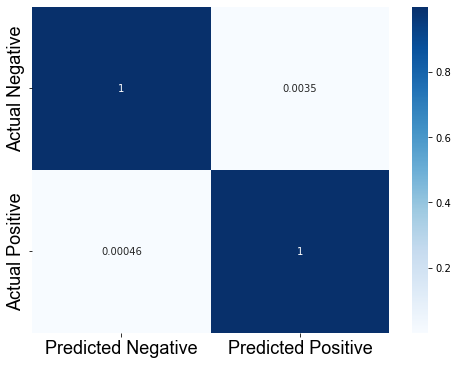

In [46]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred_labels_validation)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xticks(fontsize=18, fontfamily='Arial')
plt.yticks(fontsize=18, fontfamily='Arial')
# plt.savefig('confusion_matrix.svg', dpi=300)


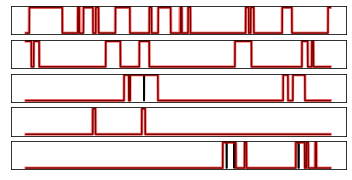

In [47]:
plt.close()
a = y_pred_labels.ravel()
b = y.ravel()

windows = np.arange(0, len(a), 2500)

fig, ax = plt.subplots(5, 1, figsize=(6, 3))
for w, window in enumerate(windows[[0, 1, 2, 34, 29]]):
    ax[w].plot(b[window:window+2500], color='black', label='true')
    ax[w].plot(a[window:window+2500], alpha=0.5, color='red', linewidth=3, label='pred')
    ax[w].set_yticks([])
    ax[w].set_xticks([])
# plt.savefig('pred_true.svg', dpi=300)

In [84]:
# Save the trained model
model.save('MLP_041824_512units_balancedAcc&Precision.h5')

Predict labels and save resulting dictionary

In [4]:
def extract_segments(array):
    segments = []
    current_segment = []

    for i in range(len(array)):
        if i > 0 and array[i] != array[i-1] + 1:
            segments.append(np.array(current_segment))
            current_segment = []
        current_segment.append(array[i])

    if current_segment:
        segments.append(np.array(current_segment))

    return segments

def concatenate_arrays(arrays, distance_of_frames=2):
    result = []
    current_array = arrays[0]

    for i in range(1, len(arrays)):
        if arrays[i][0] - current_array[-1] <= distance_of_frames:
            current_array = np.concatenate((current_array, arrays[i]))
            current_array = fill_missing_numbers(current_array)
        else:
            result.append(current_array)
            current_array = arrays[i]

    result.append(current_array)
    return np.array(result)

def process_binary_labels(labels):
    
    segments = extract_segments(np.where(labels==1)[0])
    joined_segments = concatenate_arrays(segments)
    new_labels = generate_binary_array(np.concatenate(joined_segments), labels.shape[0])
    
    return new_labels

def generate_binary_array(indices, length):
    binary_array = np.zeros(length)
    binary_array[indices] = 1
    return binary_array


def fill_missing_numbers(array):
    filled_array = []
    for i in range(len(array) - 1):
        filled_array.append(array[i])
        diff = array[i + 1] - array[i]
        if diff > 1:
            filled_array.extend(np.arange(array[i] + 1, array[i + 1]))
    filled_array.append(array[-1])
    return filled_array

In [35]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('MLP_041824_512units_balancedAcc&Precision.h5', custom_objects={'balanced_accuracy_metric': balanced_accuracy_metric, 'precision_metric': precision_metric})

# labeled_data = {}

# for key in features.keys():
#     if key.split('_')[0] in ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '29L', '30R2', '87R2', '87L', '87B', '87L2', '86L', '86L2']:
#         fts = features[key].to_numpy()
#         y_pred = loaded_model.predict(fts)
#         y_pred_labels = (y_pred > 0.5).astype(int)
#         if len(np.where(y_pred_labels==1)[0]) == 0:
#             labeled_data[key] = y_pred_labels
#         else:
#             labeled_data[key] = process_binary_labels(y_pred_labels)

In [95]:
with open("supervised_aggression_labels_041824.pickle", "wb") as file:
    pickle.dump(labeled_data, file)

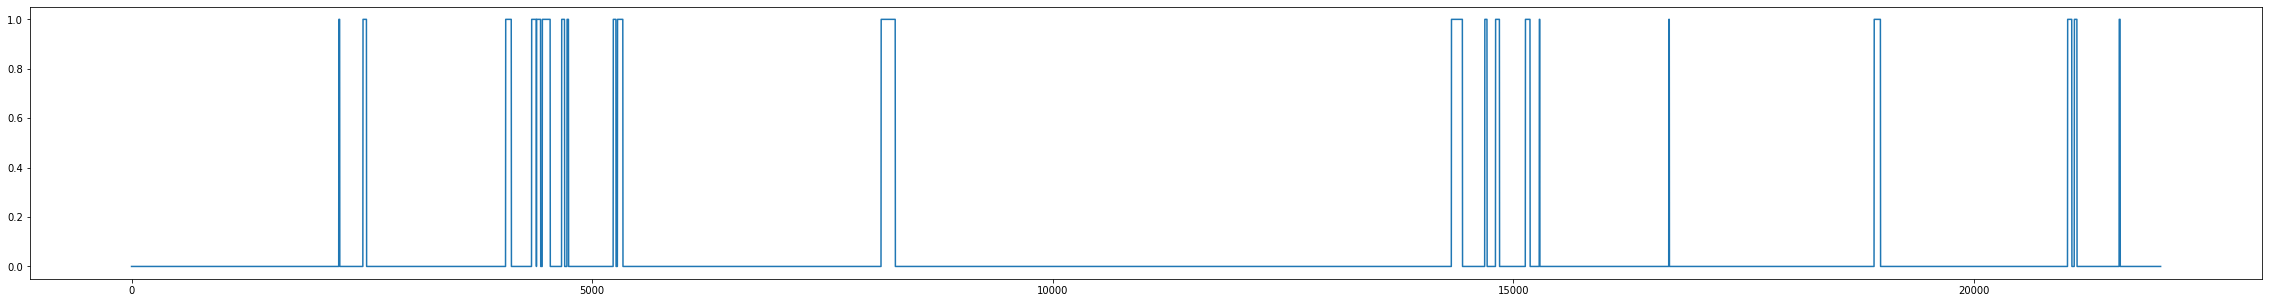

In [114]:
plt.figure(figsize=(40, 5))
plt.plot(labeled_data['30L_d2_balbc_t3'])

Merge supervised labels with photometry and unsupervised dataset

In [45]:
supervised = pd.read_pickle('supervised_labels_smoothed_061423.pickle')
full_data = pd.read_pickle('traces_with_labels_060623.pickle')

In [46]:
complete_data = {}

for key in full_data.keys():
    labels = supervised[key]
    df = full_data[key].copy()
    df['supervised labels'] = labels.astype(int)
    complete_data[key] = df
    
with open("fully_labeled_traces_smoothedLabels_061423.pickle", "wb") as file:
    pickle.dump(complete_data, file)